In [ ]:

# Pavlogeorgatos Dionysios, AM: p2822016

# Tsachtsarlis Ilias, AM: p2822019

In [1445]:
# Libraries

import os
from glob import glob
from typing import Tuple, List
import pandas as pd
import numpy as np
from tensorflow.python.keras.layers import Embedding, Flatten, Dense
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.keras import layers
from tqdm import tqdm
from ipywidgets import interact

In [1446]:
# Synced with google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1447]:
# Set seed is used to save the state of a random function, so that it can generate same random numbers on multiple executions of the code
import random
random.seed(10)

In [1448]:
# Load Dataset
# The resulting dataset has one abstract per row. The sentences and the labels are list items.

In [1449]:
import json
import pandas as pd

label2id = {
    'NONE': 0,
    'EVIDENCE': 1,
    'CLAIM': 2}

def load_corpus(path, label_mapping=None):
  with open(path) as fp:
      corpus = json.load(fp)
  documents, texts, labels = [], [], []
  for abstract in corpus:
      documents.append(abstract)
      texts.append(corpus[abstract]['sentences'])
      if isinstance(label_mapping, dict):
        labels.append(
            [label_mapping[str(l).upper()]
             for l in corpus[abstract]['labels']])
      else:
        labels.append([str(l).upper() for l in corpus[abstract]['labels']])

  assert len(texts) == len(labels)
  data = pd.DataFrame(
      zip(documents, texts, labels),
      columns=['document', 'sentences', 'labels'])

  return data

data_1 = load_corpus('dataset_aueb_argument_v3.json')
data_2 = load_corpus('dataset.json') 

print(f'dataset_aueb_argument_v3 length: {len(data_1)} abstracts')
print(f'dataset length: {len(data_2)} abstracts')

print(f'data_1 column names: {data_1.columns}')
print(f'data_2 column names: {data_2.columns}')

data = data_1.append(data_2, ignore_index=True, sort=False)
print()

print(f' data_1 dimensions: {data_1.shape}','\n',
    f'data_2 dimensions: {data_2.shape}','\n',
    f'and the merged dataset dimensions: {data.shape}')

data.sample(5)

dataset_aueb_argument_v3 length: 1017 abstracts
dataset length: 1669 abstracts
data_1 column names: Index(['document', 'sentences', 'labels'], dtype='object')
data_2 column names: Index(['document', 'sentences', 'labels'], dtype='object')

 data_1 dimensions: (1017, 3) 
 data_2 dimensions: (1669, 3) 
 and the merged dataset dimensions: (2686, 3)


document  ...                                             labels
1942  RST_G7B4_S0033589414001379.txt  ...    [NONE, NONE, NONE, EVIDENCE, NONE, CLAIM, NONE]
2327                        11142481  ...  [NONE, NONE, NONE, NONE, NONE, EVIDENCE, EVIDE...
2091                        22508621  ...  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...
1522      HOP_G6B3_PMID-30308471.txt  ...  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, EVI...
932        doi: 10.3390/ijms19010038  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...

[5 rows x 3 columns]

In [1450]:
# Shuffle the rows of the data frame
data = data.sample(frac=1).reset_index(drop=True)
data

document  ...                                             labels
0          LST_G5B2_10.1145_3070617.3070635.txt  ...  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, EVI...
1                IJK_G4B2_CorpusID_43703653.txt  ...  [NONE, NONE, NONE, NONE, NONE, NONE, EVIDENCE,...
2                 doi: 10.3389/fphys.2018.00458  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
3                 doi: 10.5194/gmd-11-3681-2018  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
4                                      17075117  ...  [NONE, NONE, NONE, NONE, NONE, EVIDENCE, EVIDE...
...                                         ...  ...                                                ...
2681                     doi: 10.1038/srep44665  ...  [NEITHER, NEITHER, NEITHER, EVIDENCE, EVIDENCE...
2682                                   23873790  ...  [NONE, NONE, NONE, NONE, NONE, EVIDENCE, EVIDE...
2683  ABC_G1B1_10.1016_j.envint.2017.01.012.txt  ...  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...
2684                     doi: 10.1111/gcb.14504  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
2685              doi: 10.1175/bams-d-19-0040.1  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...

[2686 rows x 3 columns]

In [1451]:
# Exploratory Data Anaylsis

In [1452]:
# Some extra info for the dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2686 entries, 0 to 2685
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   document   2686 non-null   object
 1   sentences  2686 non-null   object
 2   labels     2686 non-null   object
dtypes: object(3)
memory usage: 63.1+ KB


In [1453]:
# Convert NONE to NEITHER sentences' labels

for i in range(0,data.shape[0]):
  for j in range(0, len(data.sentences[i])):
    if data.labels[i][j] == 'NONE':
      data.labels[i][j] = 'NEITHER'
data.tail()  

document  ...                                             labels
2681                     doi: 10.1038/srep44665  ...  [NEITHER, NEITHER, NEITHER, EVIDENCE, EVIDENCE...
2682                                   23873790  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
2683  ABC_G1B1_10.1016_j.envint.2017.01.012.txt  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
2684                     doi: 10.1111/gcb.14504  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
2685              doi: 10.1175/bams-d-19-0040.1  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...

[5 rows x 3 columns]

In [1454]:
# Before title removal, sentences and labels count of elements
print(f'With title sentences: {len(data.sentences[2])} and the matched labels {len(data.labels[2])} ')                                  

With title sentences: 12 and the matched labels 12 


In [1455]:
# Removing titles
for i in range(0,data.shape[0]):
  data.labels[i].pop(0)
  data.sentences[i].pop(0)

print("Now the length reduced by one, accounting the title removal on the third abstract ", len(data['labels'][2] ))

Now the length reduced by one, accounting the title removal on the third abstract  11


In [1456]:
# Validation of the titles removal, reduced by one
print(f'Without title sentences: {len(data.sentences[2])} and the matched labels {len(data.labels[2])} ')                                  

Without title sentences: 11 and the matched labels 11 


In [1457]:
# Creation of data frame that will be used for the Graph embeddings
data2 = data 

In [1458]:
# Isolating our dataset into independent (X) and dependent (Y) variables
X = data.sentences
y = data.labels

In [1459]:

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split


In [1460]:
# Split train test dataset 
X_train_val, X_test, y_train_val, y_test = train_test_split(X,
                                                            y,
                                                            test_size=0.2,
                                                            random_state=42)

In [1461]:
# Check here the indexes 
X_train_val.head()

57      [Abstract Macrophages play a crucial rule in o...
2594    [International audience; The spread of Zika vi...
1886    [International audience; Viral RNA-dependent R...
229     [Abstract This work explored polysulfone (PS) ...
1380    [Understanding spatiotemporal patterns of clim...
Name: sentences, dtype: object

In [1462]:
# Splitting X_train_val in separate train and validation sets

X_train, X_val, y_train, y_val = train_test_split(X_train_val,
                                                  y_train_val,
                                                  test_size=0.20, 
                                                  random_state=42
                                                  )

In [1463]:
# Overview of datasets dimensions after splitting

print(f'X_train_val shape: {X_train_val.shape}')
print(f'y_train_val shape: {y_train_val.shape}')
print()

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print()

print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

print()
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train_val shape: (2148,)
y_train_val shape: (2148,)

X_train shape: (1718,)
y_train shape: (1718,)

X_val shape: (430,)
y_val shape: (430,)

X_test shape: (538,)
y_test shape: (538,)


In [1464]:
# Here we filter the initial dataset (data) only for the indexes including in the training dataset (1654 rows)

ind_train = X_train.index.tolist()
print(f'Indexes of X train: {len(ind_train)}')
data = data.filter(items = ind_train, axis=0)
data.reset_index(drop=True,inplace=True)
print(data.shape)
data.head()

Indexes of X train: 1718
(1718, 3)


document  ...                                             labels
0                                   29364091  ...  [NEITHER, NEITHER, EVIDENCE, EVIDENCE, EVIDENC...
1              DJK_G4B3_CorpusID_2377085.txt  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
2                                   19347979  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
3                doi: 10.1126/sciadv.aaz9549  ...                [NEITHER, NEITHER, EVIDENCE, CLAIM]
4  ABC_G1B2_10.1016_j.renene.2018.08.069.txt  ...  [NEITHER, NEITHER, NEITHER, NEITHER, EVIDENCE,...

[5 rows x 3 columns]

In [1465]:
# Distribution of labels investigation process

cnt_claim = 0
cnt_evid  = 0 
cnt_none = 0

for index,row in data.iterrows():
  for i in row['labels']:
    if i == 'CLAIM':
      cnt_claim = cnt_claim + 1
    elif i == 'EVIDENCE': 
      cnt_evid = cnt_evid + 1
    else:
      cnt_none = cnt_none + 1


Text(0.5, 1.0, 'Occurences per Sentence')

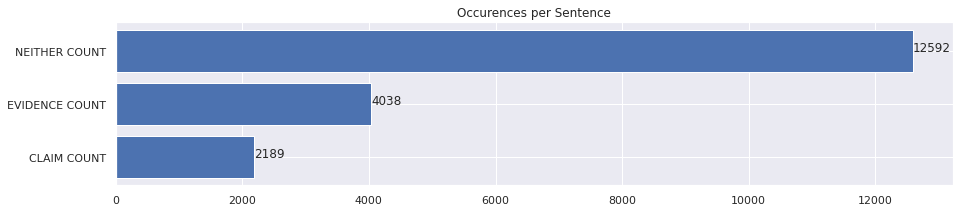

In [1466]:
# Visual representation of labels distribution

import matplotlib.pyplot as plt

df = pd.DataFrame({'count_claim': [cnt_claim], 'count_evidence': [cnt_evid],'count_none':[cnt_none]})

names = ['CLAIM COUNT', 'EVIDENCE COUNT', 'NEITHER COUNT']
values = [df['count_claim'][0], df['count_evidence'][0], df['count_none'][0]]

plt.figure(figsize=(15, 3))

plt.barh(names, values)

for index, val in enumerate(values):
    plt.text(val, index, str(val))

plt.title("Occurences per Sentence")


Text(0.5, 1.0, 'Percentages of Labels Distribution')

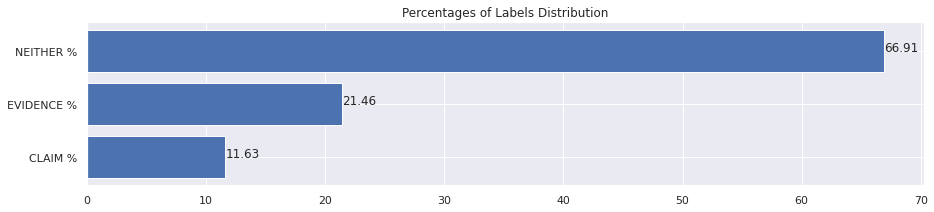

In [1467]:
names  = ['CLAIM %', 'EVIDENCE %', 'NEITHER %']
deno   = (df['count_claim'][0] + df['count_evidence'][0] + df['count_none'][0])/100
values = [df['count_claim'][0]/deno, df['count_evidence'][0]/deno, df['count_none'][0]/deno]
values = [round(val, 2) for val in values]

plt.figure(figsize=(15, 3))

plt.barh(names, values)

for index, val in enumerate(values):
    plt.text(val, index, str(val))

plt.title("Percentages of Labels Distribution")

In [1468]:
# Isolation of sentences in order investigate it further 
sentences = data['sentences'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'sentences': 'sentence'})

print(f'sentences dimension: {sentences.shape}')
sentences.head(10)


sentences dimension: (18819, 2)


doc_id                                           sentence
0       0  This study aimed to observe and compare the ef...
1       0  A total of 127 patients with decompensated cir...
2       0  At the end of the treatment, the level of alan...
3       0  For the 24-week optimized therapy group, only ...
4       0  There were no obvious differences in the norma...
5       0  However, the difference among these three grou...
6       0  Differences were not observed in the HBeAg ser...
7       0  Differences in blood urea nitrogen, serum crea...
8       0  Combination therapy and early ADV addition wer...
9       1                                         Background

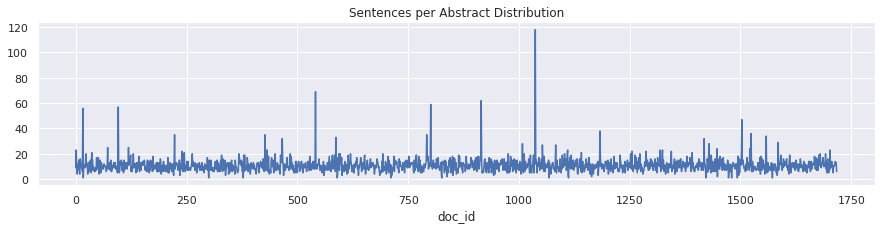

In [1469]:
# sentences per abstract
#import matplotlib as plt

sentences.groupby(['doc_id']).agg([ 'count']).plot(figsize=(15, 3),title='Sentences per Abstract Distribution',legend= False)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


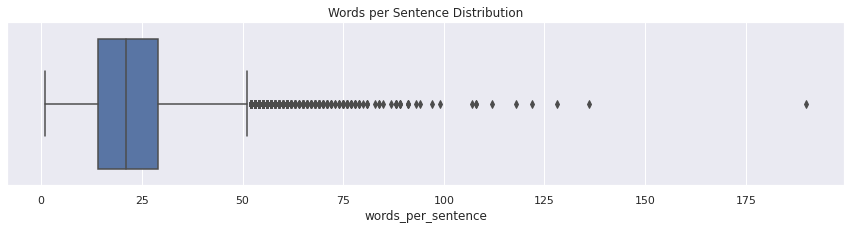

In [1470]:
# Words per Sentence Distribution
sentences['split_sent'] = sentences['sentence'].str.split(' ')
sentences['words_per_sentence'] = sentences.split_sent.apply(lambda x: len(x)) 

import seaborn as sns
sns.set_theme(style="whitegrid")

sns.set(rc={'figure.figsize':(15,3)})
ax = sns.boxplot(sentences['words_per_sentence']).set_title("Words per Sentence Distribution")

In [1471]:
# Count the number of Unique Words containing in the senteces
sent = sentences['split_sent'].explode().reset_index()
sent['split_sent'] = sent['split_sent'].map(lambda x: x.lower())
#sent.split_sent.nunique()

print(f'The number of unique words in the sentences of our data is: {sent.split_sent.nunique() }')

The number of unique words in the sentences of our data is: 45600


In [1472]:
# Isolation of labels in order investigate it further 
labels = data['labels'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'labels': 'label'})
print(f'labels dimension: {labels.shape}')
labels.head(10)

labels dimension: (18819, 2)


doc_id     label
0       0   NEITHER
1       0   NEITHER
2       0  EVIDENCE
3       0  EVIDENCE
4       0  EVIDENCE
5       0  EVIDENCE
6       0  EVIDENCE
7       0  EVIDENCE
8       0     CLAIM
9       1   NEITHER

In [1473]:
# Merge the 2 datasets sentences and labels  
data_exp  = pd.concat([sentences,labels['label']], axis=1)
print(data_exp.shape)
data_exp.head(20)

(18819, 5)


doc_id  ...     label
0        0  ...   NEITHER
1        0  ...   NEITHER
2        0  ...  EVIDENCE
3        0  ...  EVIDENCE
4        0  ...  EVIDENCE
5        0  ...  EVIDENCE
6        0  ...  EVIDENCE
7        0  ...  EVIDENCE
8        0  ...     CLAIM
9        1  ...   NEITHER
10       1  ...   NEITHER
11       1  ...   NEITHER
12       1  ...   NEITHER
13       1  ...   NEITHER
14       1  ...   NEITHER
15       1  ...   NEITHER
16       1  ...   NEITHER
17       1  ...   NEITHER
18       1  ...   NEITHER
19       1  ...   NEITHER

[20 rows x 5 columns]

In [1474]:
# Filter only for evidence 
evidence =  pd.DataFrame(data_exp[data_exp['label'] == 'EVIDENCE']['sentence'])
evidence.head()

sentence
2  At the end of the treatment, the level of alan...
3  For the 24-week optimized therapy group, only ...
4  There were no obvious differences in the norma...
5  However, the difference among these three grou...
6  Differences were not observed in the HBeAg ser...

In [1475]:
# Performing some very basic tokenization to extract STOPWORDS
# converting all sentences to lowercase and replacing the dots (".") with space (" ")
evidence = evidence['sentence'].str.lower().str.replace('.', ' ', regex=False)
evidence.head()

2    at the end of the treatment, the level of alan...
3    for the 24-week optimized therapy group, only ...
4    there were no obvious differences in the norma...
5    however, the difference among these three grou...
6    differences were not observed in the hbeag ser...
Name: sentence, dtype: object

In [1476]:
# A pandas Series is also an iterable. So we can handle it like a List.
# Concatenating all sentences into one text
corpora_evid = " ".join(evidence)
print(corpora_evid[:1000])
print(f'First feeling of corpora evidence size: {len(corpora_evid)} ')

at the end of the treatment, the level of alanine amino-transferase (alt), albumin (alb) and total bilirubin (tbil) in the combination therapy group and 12-week optimized therapy group were significantly improved  for the 24-week optimized therapy group, only alt levels revealed a significant improvement  there were no obvious differences in the normalization rate of alt, negative conversion rate of hbv dna and hbeag, as well as improvement in child-pugh scores among the combination therapy group, 12-week optimized therapy group, and etv monotherapy group  however, the difference among these three groups and the 24-week optimized therapy group were significant  differences were not observed in the hbeag seroconversion between each group  differences in blood urea nitrogen, serum creatinine, creatine kinase, or other serious adverse effects were not observed in each group at the end of the 96-week treatment  the lifetime domestic physical violence by husband or intimate partner against 

In [1477]:
# word tokenization - process of splitting a large text into words
from nltk import word_tokenize
import nltk
nltk.download('punkt')
tokens_evid = word_tokenize(corpora_evid)
print(tokens_evid)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
['at', 'the', 'end', 'of', 'the', 'treatment', ',', 'the', 'level', 'of', 'alanine', 'amino-transferase', '(', 'alt', ')', ',', 'albumin', '(', 'alb', ')', 'and', 'total', 'bilirubin', '(', 'tbil', ')', 'in', 'the', 'combination', 'therapy', 'group', 'and', '12-week', 'optimized', 'therapy', 'group', 'were', 'significantly', 'improved', 'for', 'the', '24-week', 'optimized', 'therapy', 'group', ',', 'only', 'alt', 'levels', 'revealed', 'a', 'significant', 'improvement', 'there', 'were', 'no', 'obvious', 'differences', 'in', 'the', 'normalization', 'rate', 'of', 'alt', ',', 'negative', 'conversion', 'rate', 'of', 'hbv', 'dna', 'and', 'hbeag', ',', 'as', 'well', 'as', 'improvement', 'in', 'child-pugh', 'scores', 'among', 'the', 'combination', 'therapy', 'group', ',', '12-week', 'optimized', 'therapy', 'group', ',', 'and', 'etv', 'monotherapy', 'group', 'however', ',', 'the', 'dif

In [1478]:
# creation of collection where elements are stored as dictionary keys and their counts are stored as dictionary values for evidence
'''
Counting words
'''
from collections import Counter

count_evid= Counter(tokens_evid)

print(count_evid.most_common(10))



[(',', 5856), ('the', 4913), ('and', 3799), (')', 3318), ('of', 3303), ('(', 3303), ('in', 3189), ('%', 2535), ('to', 1747), ('0', 1559)]


In [1479]:
# Removing stopwords
nltk.download(u'stopwords')

from nltk.corpus import stopwords
import nltk 
import pprint
# there are also some english stopwords in the Scikit-learn package.
en_stop = stopwords.words('english')
 
filtered_evid = [w for w in tokens_evid if not w in en_stop]

count_evid = Counter(filtered_evid)

print(count_evid.most_common(10))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[(',', 5856), (')', 3318), ('(', 3303), ('%', 2535), ('0', 1559), ('p', 1218), ('=', 1122), (';', 892), ('1', 807), ('group', 765)]


In [1480]:
# Creation of evid_df dataframe to remove additional not intuitive words
evid_df = pd.DataFrame(count_evid,index = ['number']).transpose().sort_values(by = 'number',ascending = False).reset_index().rename(columns={"index": "words"})
print(evid_df.shape)
evid_df.head(10)


(12420, 2)


words  number
0      ,    5856
1      )    3318
2      (    3303
3      %    2535
4      0    1559
5      p    1218
6      =    1122
7      ;     892
8      1     807
9  group     765

In [1481]:
# Remove all the digits 
evid_df['words'] = evid_df['words'].str.replace('\d+', '0')
evid_df.drop(evid_df.index[evid_df['words'] == '0'], inplace = True)
print(evid_df.shape)
evid_df.head()

(11761, 2)


words  number
0     ,    5856
1     )    3318
2     (    3303
3     %    2535
5     p    1218

In [1482]:
# Now, we remove some additional not symbols
symbols_evid = [',',')', '(', ';',':',':','[',']','-0','0/0','0,0','−0','+0','0·0']

for i in symbols_evid:
  evid_df.drop(evid_df.index[evid_df['words'] == i], inplace = True)

# We store the evidence common words in a new dataframe called evidence_com_words
evidence_com_words=evid_df

print(f'count_df dimensions: {evid_df.shape}')
evid_df.head(10)


count_df dimensions: (11494, 2)


words  number
3               %    2535
5               p    1218
6               =    1122
9           group     765
10       patients     683
11              <     526
15             ci     460
17         months     426
21    significant     389
22  significantly     384

Text(0.5, 1.0, 'Frequency distribution of most common evidence words')

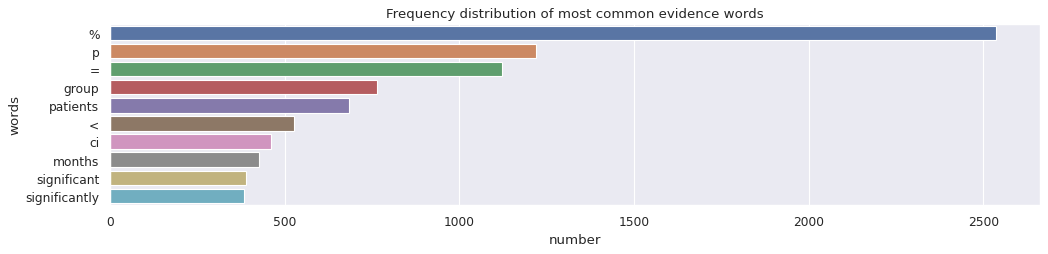

In [1483]:
# Visualize the frequency distribution  of the 10 most common words in evidence dataframe
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize=(15, 3), dpi=80)
sns.barplot(x='number',y='words',data=evid_df.head(10)).set_title('Frequency distribution of most common evidence words')

In [1484]:
# Filter only for claims
claims =  pd.DataFrame(data_exp[data_exp['label'] == 'CLAIM']['sentence'])
claims.head()

sentence
8   Combination therapy and early ADV addition wer...
29  Domestic violence against women was relatively...
30  Domestic violence has direct relationship with...
40  Genotypes of glutathione-related enzymes, espe...
41  GPX1 may be an inherited factor in predicting ...

In [1485]:
# Performing some very basic tokenization to extract STOPWORDS
# converting all sentences to lowercase and replacing the dots (".")  with space (" ")
claims = claims['sentence'].str.lower().str.replace('.', ' ', regex=False)
claims.head()

8     combination therapy and early adv addition wer...
29    domestic violence against women was relatively...
30    domestic violence has direct relationship with...
40    genotypes of glutathione-related enzymes, espe...
41    gpx1 may be an inherited factor in predicting ...
Name: sentence, dtype: object

In [1486]:
# A pandas Series is also an iterable. So we can handle it like a List.
# Concatenating all sentences into one text
corpora_claims = " ".join(claims)

# word tokenization
tokens_claims = word_tokenize(corpora_claims)
print(tokens_claims)

# Removing stopwords
filtered_claims = [w for w in tokens_claims if not w in en_stop]
count_claims = Counter(filtered_claims)
print(count_claims.most_common(10))

claims_df = pd.DataFrame(count_claims,index = ['number']).transpose().sort_values(by = 'number',ascending = False).reset_index().rename(columns={"index": "words"})

claims_df['words'] = claims_df['words'].str.replace('\d+', '0')
claims_df.drop(claims_df.index[claims_df['words'] == '0'], inplace = True)
# Now, we remove some additional not symbols
symbols_claims = [',',')', '(', ';',':',':','[',']']

for i in symbols_claims:
  claims_df.drop(claims_df.index[claims_df['words'] == i], inplace = True)

# We store the claim common words in a new dataframe called claim_com_words
claim_com_words=claims_df

print(f'claims_df dimensions: {claims_df.shape}')
claims_df.head(10)



['combination', 'therapy', 'and', 'early', 'adv', 'addition', 'were', 'the', 'preferred', 'approaches', 'in', 'the', 'antiviral', 'strategy', 'for', 'the', 'treatment', 'of', 'hepatitis', 'b-induced', 'decompensated', 'cirrhosis', 'domestic', 'violence', 'against', 'women', 'was', 'relatively', 'high', 'in', 'different', 'parts', 'of', 'ethiopia', 'domestic', 'violence', 'has', 'direct', 'relationship', 'with', 'sociodemographic', 'characteristics', 'of', 'the', 'victim', 'as', 'well', 'as', 'perpetrator', 'genotypes', 'of', 'glutathione-related', 'enzymes', ',', 'especially', 'gclc', ',', 'may', 'be', 'used', 'as', 'host', 'factors', 'in', 'predicting', 'patients', "'", 'survival', 'after', 'platinum-based', 'chemotherapy', 'gpx1', 'may', 'be', 'an', 'inherited', 'factor', 'in', 'predicting', 'patients', "'", 'qol', 'further', 'investigation', 'to', 'define', 'and', 'measure', 'the', 'effects', 'of', 'these', 'genes', 'in', 'chemotherapeutic', 'regimens', ',', 'drug', 'toxicities', ',

words  number
1      patients     338
5     treatment     176
6       results     166
7   conclusions     161
8        cancer     156
9        health     150
10          may     149
11   associated     141
12        study     141
13      climate     126

Text(0.5, 1.0, 'Frequency distribution of most common claim words')

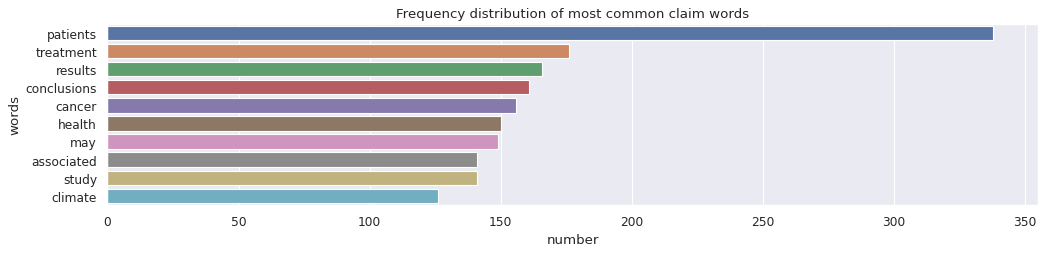

In [1487]:
# Visualize the frequency distribution  of the 10 most common words in claim dataframe
import seaborn as sns
from matplotlib.pyplot import figure
figure(figsize=(15, 3), dpi=80)
sns.barplot(x='number',y='words',data=claims_df.head(10)).set_title('Frequency distribution of most common claim words')

In [1488]:
# Print the 50 most common words in evidence and claim dataframe 
#claim_com_words=count_df
print('Evidence')
print(evidence_com_words.head(50))
print()
print('Claims')
print( claim_com_words.head(50))

Evidence
            words  number
3               %    2535
5               p    1218
6               =    1122
9           group     765
10       patients     683
11              <     526
15             ci     460
17         months     426
21    significant     389
22  significantly     384
25        results     304
26       compared     296
28   respectively     283
32         groups     257
33         higher     254
34           mean     251
35      treatment     236
36       survival     234
37             vs     224
38          women     218
39     difference     216
40     associated     214
41         health     211
42      increased     201
43         median     191
44            arm     189
45         scores     185
46       observed     182
47    differences     181
48          lower     177
49       baseline     177
50           rate     177
52           time     171
53         showed     171
54         versus     166
55       reported     166
56        overall     165
57 

In [1489]:
# Get the dimension of the evidence and claim dataframes
print(evidence_com_words.shape)
print(claim_com_words.shape)

(11494, 2)
(8025, 2)


In [1490]:
# In this step, we observe that some of the words are not intuitive about the categorization in evidence/claim, occured by chance
# So, we remove them from the analysis
# From the analysis, below we see that the first 3000 words of evidence and claim data frames are responsible for the 80% of the total number of words

In [1491]:
# We  set a threshold at 80%  
print(evidence_com_words.number.head(3000).sum() / evidence_com_words.number.sum())
print(claim_com_words.number.head(3000).sum() / claim_com_words.number.sum())


0.8221581860923637
0.8241798521595699


In [1492]:
# Filtering out after the threshold set
evidence_com_words = evidence_com_words.head(3000)
claim_com_words = claim_com_words.head(3000)

In [1493]:
# Outer join to keep the uncommon words and the to filter with those the 2 dataframes

mergerd_words =pd.merge(evidence_com_words,
         claim_com_words,
         on='words',
         how='outer',
         indicator=True)
print(mergerd_words.shape)
mergerd_words.head()

(4097, 4)


words  number_x  number_y _merge
0         %    2535.0      48.0   both
1         p    1218.0      16.0   both
2         =    1122.0      11.0   both
3     group     765.0      32.0   both
4  patients     683.0     338.0   both

In [1494]:
# Number of cases for each occasion
mergerd_words['_merge'].value_counts()

both          1908
right_only    1097
left_only     1092
Name: _merge, dtype: int64

In [1495]:
# Drop the common words between claims and evidence
mergerd_words.drop(mergerd_words.index[mergerd_words['_merge'] == 'both'], inplace = True)
print(mergerd_words.shape)

(2189, 4)


In [1496]:
# Unique words isolated and creation of the list 
unique_words=mergerd_words.words.to_list()
print(len(unique_words))
unique_words[:10]

2189


['respectively', 'p=0', 'mm', 'hr', 'hg', 'v', 'mmhg', '±', '+/-', 'hazard']

In [1497]:
# Filtered with unique words
claim_com_words = claim_com_words[claim_com_words['words'].isin(unique_words)]
evidence_com_words = evidence_com_words[evidence_com_words['words'].isin(unique_words)]

print(evidence_com_words.shape,'evidence')
print(claim_com_words.shape,'claim')

(1092, 2) evidence
(1097, 2) claim


In [1498]:
# Study of claim and evidence words distribution

In [1499]:
claim_com_words.sort_values(by='number',ascending=False)

words  number
14    conclusion     120
140         safe      32
151        nsclc      31
154     improves      30
251     conclude      22
...          ...     ...
2638  pollutants       2
2636        gcms       2
2635      sodium       2
2633    americas       2
3040     degrees       2

[1097 rows x 2 columns]

In [1500]:
evidence_com_words.sort_values(by='number',ascending=False)

words  number
28     respectively     283
57              p=0     162
88               mm     113
95               hr     109
107              hg      98
...             ...     ...
3089      neorectal       3
3088           lean       3
3087    accumulated       3
3086        typical       3
3222  possibilities       3

[1092 rows x 2 columns]

In [1501]:
# Distribution of claim 

In [1502]:
# In this step, we try to find the exact position of the claims
# In our analysis we analyze the 3 last sentences of each argument

In [1503]:
t1 = pd.DataFrame()

for i in range(0,data.shape[0]):

    if (data.labels[i][-1]=='CLAIM') :
      t1.loc[i,'claim_fin_sent'] = 1 
    else: 
      t1.loc[i,'claim_fin_sent'] = 0
    
    if (len(data.labels[i])>=2): 
      if (data.labels[i][-2]=='CLAIM'):
        t1.loc[i,'claim_prefin_sent'] = 1 
      else: 
        t1.loc[i,'claim_prefin_sent'] = 0
    if (len(data.labels[i])>=3):
      if (data.labels[i][-3]=='CLAIM'):
        t1.loc[i,'claim_3rdprefin_sent'] = 1 
      else: 
        t1.loc[i,'claim_3rdprefin_sent'] = 0

print(t1.shape)
print(t1.head(50))


(1718, 3)
    claim_fin_sent  claim_prefin_sent  claim_3rdprefin_sent
0              1.0                0.0                   0.0
1              0.0                1.0                   1.0
2              1.0                1.0                   1.0
3              1.0                0.0                   0.0
4              1.0                0.0                   0.0
5              1.0                0.0                   0.0
6              1.0                0.0                   0.0
7              0.0                0.0                   0.0
8              0.0                0.0                   0.0
9              0.0                0.0                   0.0
10             0.0                1.0                   0.0
11             1.0                0.0                   0.0
12             1.0                0.0                   0.0
13             0.0                1.0                   1.0
14             1.0                0.0                   0.0
15             1.0            

In [1504]:
# Here, we investigate the cases where the claims are in the last 2 sentences of the abstracts

In [1505]:
def f(row):
    if (row['claim_fin_sent'] == 1) and (row['claim_prefin_sent']==1):
        val = 1
    else:
        val = 0
    return val

t1['common'] = t1.apply(f, axis=1)
t1.head()
t1.sum()

claim_fin_sent          1001.0
claim_prefin_sent        613.0
claim_3rdprefin_sent     230.0
common                   290.0
dtype: float64

In [1506]:
# Find the Distribution of the claim in the last 3 sentences of each abstract

In [1507]:
print("Claim in the final sentence in the:", round(t1.claim_fin_sent.sum()/t1.shape[0]*100,2),"% of the cases")
print("Claim in the pre final sentence in the:", round(t1.claim_prefin_sent.sum()/t1.shape[0]*100,2),"% of the cases")
print("Claim in the pre pre final sentence in the:", round(t1.claim_3rdprefin_sent.sum()/t1.shape[0]*100,2),"% of the cases" )
print("The % of existence claim in the 2 last sentences of the abstracts concurently, equals to", round(t1.common.sum()/t1.shape[0]*100,2),"%")

Claim in the final sentence in the: 58.27 % of the cases
Claim in the pre final sentence in the: 35.68 % of the cases
Claim in the pre pre final sentence in the: 13.39 % of the cases
The % of existence claim in the 2 last sentences of the abstracts concurently, equals to 16.88 %


In [1508]:
# Visualize the distribution of claim existence in the 3 last sentences of the abstracts 
# Visualize the % of the concurent claim existence in the last 2 sentences of the abstracts (Common Final & Pre Final)

Text(0.5, 1.0, 'Claim % Distribution')

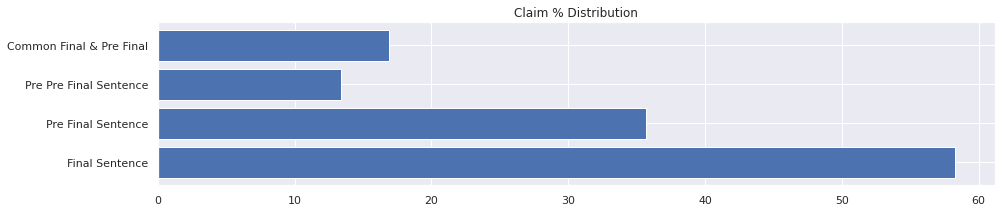

In [1509]:
names = ['Final Sentence', 'Pre Final Sentence', 'Pre Pre Final Sentence','Common Final & Pre Final']

values = [round(t1.claim_fin_sent.sum()/t1.shape[0]*100,2),
round(t1.claim_prefin_sent.sum()/t1.shape[0]*100,2),
round(t1.claim_3rdprefin_sent.sum()/t1.shape[0]*100,2),
round(t1.common.sum()/t1.shape[0]*100,2)]

import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 3))
plt.barh(names, values)
plt.title("Claim % Distribution")

In [1510]:
# Creation of 2 lists for claim and evidence

In [1511]:
claim_list = claim_com_words['words'].tolist()
evid_list = evidence_com_words['words'].tolist()

In [1512]:
print(len(evid_list))
print(len(claim_list))

1092
1097


In [1513]:
# Filter for the 100 first words for claim and evidence

In [1514]:
claim_list = claim_list[:100]
evid_list = evid_list[:800]  

In [1515]:
data

document  ...                                             labels
0                                      29364091  ...  [NEITHER, NEITHER, EVIDENCE, EVIDENCE, EVIDENC...
1                 DJK_G4B3_CorpusID_2377085.txt  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
2                                      19347979  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
3                   doi: 10.1126/sciadv.aaz9549  ...                [NEITHER, NEITHER, EVIDENCE, CLAIM]
4     ABC_G1B2_10.1016_j.renene.2018.08.069.txt  ...  [NEITHER, NEITHER, NEITHER, NEITHER, EVIDENCE,...
...                                         ...  ...                                                ...
1713           doi: 10.1016/j.hrthm.2018.05.016  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
1714             MNS_G7B2_S0959652614000171.txt  ...  [NEITHER, NEITHER, EVIDENCE, NEITHER, NEITHER,...
1715                                   12383808  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
1716                                   20351334  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
1717       doi: 10.1016/j.earscirev.2020.103110  ...  [NEITHER, CLAIM, NEITHER, NEITHER, CLAIM, NEIT...

[1718 rows x 3 columns]

In [1516]:
# Baseline model
# In the initial dataset, for each row iterate over the lists of the sentences in a reverse order 
# Creation of heuristic lists based on the claim and evidence lists we have created above  

In [1517]:
# Baseline Model

import numpy as np
data['heurclass'] = np.empty((len(data), 0)).tolist()


for i in range(0,data.shape[0]):
  c = 0
  e=0
  for j in range(-1, -(len(data.sentences[i])+1),-1):
    a = data.sentences[i][j].split()
    
    if any(i in claim_list for i in a) and c<=2:
      data.heurclass[i].insert(0,'CLAIM')
      c = c + 1
    elif any(i in evid_list for i in a) and c>=1 and e<=2:
      data.heurclass[i].insert(0,'EVIDENCE')
      e=e+1
    else:
      data.heurclass[i].insert(0,'NEITHER')


In [1518]:
# Count the number of cases in the heuristic model

In [1519]:
base_cnt_claim = 0
base_cnt_evid  = 0 
base_cnt_none = 0

for index,row in data.iterrows():
  for i in row['heurclass']:
    if i == 'CLAIM':
      base_cnt_claim = base_cnt_claim + 1
    elif i == 'EVIDENCE': 
      base_cnt_evid = base_cnt_evid + 1
    else:
      base_cnt_none = base_cnt_none + 1


df = {'base_count_claim': [base_cnt_claim], 'base_count_evidence': [base_cnt_evid],'base_count_none':[base_cnt_none]}  

df2 = pd.DataFrame(df)  
import matplotlib.pyplot as plt

In [1520]:
# Vizualize the results of the heuristic model in the training dataset

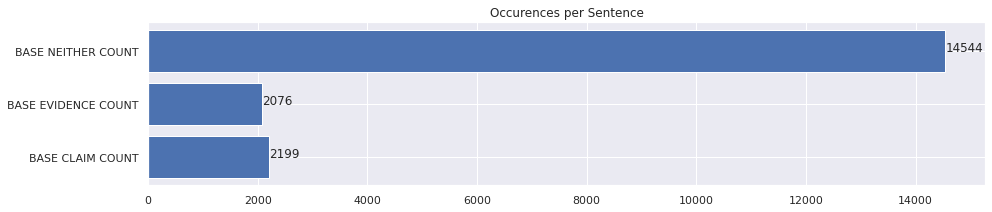

In [1521]:
names = ['BASE CLAIM COUNT', 'BASE EVIDENCE COUNT', 'BASE NEITHER COUNT']
values = [df2['base_count_claim'][0], df2['base_count_evidence'][0], df2['base_count_none'][0]]

plt.figure(figsize=(15, 3))

plt.barh(names, values)
plt.title("Occurences per Sentence")

for index, val in enumerate(values):
    plt.text(val, index, str(val))

In [1522]:
# Creation of unpivoted data frame to evaluate the accuracy of the baseline model
train_evaluation = data.set_index(['document']).apply(pd.Series.explode).reset_index()

#define conditions
conditions = [train_evaluation['labels'] == train_evaluation['heurclass'], 
              train_evaluation['labels'] != train_evaluation['heurclass']]

#define choices
choices = [1, 0]

#create new column in DataFrame that displays results of comparisons
train_evaluation['aggreement'] = np.select(conditions, choices)

print(f'The accuracy of the baseline model in the  train dataset equals to: {round(train_evaluation.aggreement.value_counts().tolist()[0]/ train_evaluation.shape[0]*100,2)} %')

The accuracy of the baseline model in the  train dataset equals to: 60.19 %


In [1523]:
# F1 Score is the weighted average of Precision and Recall

In [1524]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score
print('The accuracy of the baseline model in the train dataset with f1 scoreequals to:')
round(f1_score(train_evaluation.labels.values.flatten(), train_evaluation.heurclass.values.flatten(), average='weighted')*100,2) # macro or average

The accuracy of the baseline model in the train dataset with f1 scoreequals to:


57.76

In [1525]:
def baseline_model(data,claim_list,evid_list):
  data['heurclass'] = np.empty((len(data), 0)).tolist()
  for i in range(0,data.shape[0]):
    c = 0
    e = 0
    for j in range(-1, -(len(data.sentences[i])+1),-1):
      a = data.sentences[i][j].split()
      if any(i in claim_list for i in a) and c<=2:  #c<=2
        data.heurclass[i].insert(0,'CLAIM')
        c = c + 1
      elif any(i in evid_list for i in a) and c>=1 and e<=2:  #c>=1 added
        data.heurclass[i].insert(0,'EVIDENCE')
        e = e + 1
      else:
        data.heurclass[i].insert(0,'NEITHER')       
  return data

In [1526]:
test_evaluation_df =pd.DataFrame(X_test)
test_evaluation_df.reset_index( drop=True, inplace=True)
test_evaluation_df.head()
test_evaluation_results =baseline_model(test_evaluation_df,claim_list,evid_list)
test_evaluation_results.head()

sentences                                          heurclass
0  [Near-term climate predictions — which operate...                 [CLAIM, NEITHER, NEITHER, NEITHER]
1  [ To evaluate the effects of the Chinese medic...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
2  [ To determine the effects of exercise trainin...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
3  [Cerebral vasospasm (CVS) is a life-threatenin...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
4  [Abstract, Physical head phantoms allow the as...  [NEITHER, CLAIM, CLAIM, NEITHER, NEITHER, NEIT...

In [1527]:
test_df = pd.DataFrame(y_test)
test_df.reset_index( drop=True, inplace=True)

In [1528]:
test_evaluation_results=pd.concat([test_evaluation_results,test_df], axis=1)
test_evaluation_results.head() 

sentences  ...                                             labels
0  [Near-term climate predictions — which operate...  ...                 [NEITHER, NEITHER, NEITHER, CLAIM]
1  [ To evaluate the effects of the Chinese medic...  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
2  [ To determine the effects of exercise trainin...  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
3  [Cerebral vasospasm (CVS) is a life-threatenin...  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...
4  [Abstract, Physical head phantoms allow the as...  ...  [NEITHER, NEITHER, NEITHER, NEITHER, NEITHER, ...

[5 rows x 3 columns]

In [1529]:
# Creation of unpivoted data frame to evaluate the accuracy of the baseline model
test_evaluation = test_evaluation_results.set_index(['sentences']).apply(pd.Series.explode).reset_index()

#define conditions
conditions = [test_evaluation['labels'] == test_evaluation['heurclass'], 
              test_evaluation['labels'] != test_evaluation['heurclass']]

#define choices
choices = [1, 0]

#create new column in DataFrame that displays results of comparisons
test_evaluation['aggreement'] = np.select(conditions, choices)

print(f'The accuracy of the baseline model in the  test dataset equals to: {round(test_evaluation.aggreement.value_counts().tolist()[0]/ test_evaluation.shape[0]*100,2)} %')

The accuracy of the baseline model in the  test dataset equals to: 58.63 %


In [1530]:
# Imbalanced data so for this reason we choose weighted method for f1 score 
print('The accuracy of the baseline model in the test dataset with f1 score equals to:')
round(f1_score(test_evaluation.labels.values.flatten(), test_evaluation.heurclass.values.flatten(), average='weighted')*100,2) #micro average 

The accuracy of the baseline model in the test dataset with f1 score equals to:


56.1



---

Approach with Embeddings Starts Here!

---



In [1531]:
y_train = pd.DataFrame(y_train)
y_train = y_train['labels'].explode().reset_index().rename(columns={'index': 'doc_id', 'labels': 'label'})
y_train = y_train.label
y_train

0         NEITHER
1         NEITHER
2        EVIDENCE
3        EVIDENCE
4        EVIDENCE
           ...   
18814       CLAIM
18815     NEITHER
18816     NEITHER
18817       CLAIM
18818     NEITHER
Name: label, Length: 18819, dtype: object

In [1532]:
X_train = pd.DataFrame(X_train)
X_train = X_train['sentences'].explode().reset_index().rename(columns={'index': 'doc_id', 'sentences': 'sentences'})
X_train = X_train.sentences
X_train

0        This study aimed to observe and compare the ef...
1        A total of 127 patients with decompensated cir...
2        At the end of the treatment, the level of alan...
3        For the 24-week optimized therapy group, only ...
4        There were no obvious differences in the norma...
                               ...                        
18814    These processes result primarily from the comb...
18815    This paper reviews the current state of the ar...
18816    We identify research gaps, describe and analys...
18817    Within the scope of the review, we find that a...
18818    Further research is necessary to fully (a) inc...
Name: sentences, Length: 18819, dtype: object

In [1533]:
y_test = pd.DataFrame(y_test)
y_test = y_test['labels'].explode().reset_index().rename(columns={'index': 'doc_id', 'labels': 'label'})
y_test = y_test.label
y_test

0        NEITHER
1        NEITHER
2        NEITHER
3          CLAIM
4        NEITHER
          ...   
5815    EVIDENCE
5816    EVIDENCE
5817     NEITHER
5818       CLAIM
5819       CLAIM
Name: label, Length: 5820, dtype: object

In [1534]:
X_test = pd.DataFrame(X_test)
X_test = X_test['sentences'].explode().reset_index().rename(columns={'index': 'doc_id', 'sentences': 'sentences'})
X_test = X_test.sentences
X_test

0       Near-term climate predictions — which operate ...
1       Although skilful near-term predictions are now...
2       This Perspective discusses how these challenge...
3       Progress in this endeavour will bridge the gap...
4        To evaluate the effects of the Chinese medici...
                              ...                        
5815    At 4 months, TAM-OCT had significantly (P < .0...
5816    Older age (P = .02), tumor size (P = .001), no...
5817    Octreotide-related changes in circulating IGF-...
5818    Octreotide did not add significant clinical be...
5819    High C-peptide levels (surrogate for insulin s...
Name: sentences, Length: 5820, dtype: object

In [1535]:
y_val = pd.DataFrame(y_val)
y_val = y_val['labels'].explode().reset_index().rename(columns={'index': 'doc_id', 'labels': 'label'})
y_val = y_val.label
y_val

0       NEITHER
1       NEITHER
2       NEITHER
3       NEITHER
4       NEITHER
         ...   
4674    NEITHER
4675    NEITHER
4676    NEITHER
4677    NEITHER
4678    NEITHER
Name: label, Length: 4679, dtype: object

In [1536]:
X_val = pd.DataFrame(X_val)
X_val = X_val['sentences'].explode().reset_index().rename(columns={'index': 'doc_id', 'sentences': 'sentences'})
X_val  = X_val.sentences
X_val

0       GPR139 is an orphan G protein-coupled receptor...
1       It has therefore been suggested that GPR139 is...
2       Several surrogate agonist series have been pub...
3       Two series published by Shi et al. and Dvorak ...
4       Furthermore, Isberg et al. and Liu et al. have...
                              ...                        
4674    Five μl of the sample was injected into the ch...
4675    Aripiprazole, dehydro-aripiprazole and IS were...
4676    The method was linear in the concentration ran...
4677    Our method has been validated according to the...
4678    Our microelution-SPE method removes more than ...
Name: sentences, Length: 4679, dtype: object

In [1537]:
# Label Encoding
from sklearn.preprocessing import OneHotEncoder
# Encoding the labels using a One-Hot Encoder
y_enc = OneHotEncoder(sparse=False)

In [1538]:
# At first we run fit_transform on the train dataset
y_train_enc = y_enc.fit_transform(y_train.values.reshape(-1, 1))
y_train_enc

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

In [1539]:
# At first we run fit_transform on the test data
y_test_enc = y_enc.fit_transform(y_test.values.reshape(-1, 1))
y_test_enc

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [1540]:
# At first we run fit_transform on the validation data
y_val_enc = y_enc.fit_transform(y_val.values.reshape(-1, 1))
y_val_enc

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [1541]:
### Pre-process Dataset

In [1542]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
max_words = 22703  # We will only consider the 15K most used words in this dataset - set at 80% of the unique words

# Setting up Keras tokenizer
sentences_tokenizer = Tokenizer(num_words=max_words, lower=True, oov_token='<OOV>')

sentences_tokenizer

In [1543]:
#### Tokenization and Padding

In [1544]:
sentences_tokenizer.fit_on_texts(X_train)  # Generate tokens by counting frequency
sequences_train = sentences_tokenizer.texts_to_sequences(X_train)
print(sequences_train[20])

[1226, 187, 3326, 10, 170, 5, 21, 351]


In [1545]:
sequences_test = sentences_tokenizer.texts_to_sequences(X_test)
sequences_val = sentences_tokenizer.texts_to_sequences(X_val)

In [1546]:
# The tokenizers word index is a dictionary that maps each word to a number.
# You can see that words that are frequently used in discussions about
# movies have a lower token number.
word_index = sentences_tokenizer.word_index

for w in ['the', 'results', 'conclude']:
    print(f'Token for the word "{w}": {word_index[w]}')

Token for the word "the": 2
Token for the word "results": 39
Token for the word "conclude": 2349


In [1547]:
# To proceed, we now have to make sure that all text sequences we feed into the model
# have the same length.

# We can do this with Keras pad sequences tool.
# It cuts of sequences that are too long and adds zeros to sequences that are too short.

# Make all sequences 100 words long
maxlen = 100 # 100

data_train = pad_sequences(sequences_train, maxlen=maxlen)
data_test = pad_sequences(sequences_test,maxlen=maxlen)
data_val = pad_sequences(sequences_val,maxlen=maxlen)

# We have 25K, 100 word sequences now
print('New data shape: train {} test {} & val {}'.format(data_train.shape,data_test.shape,data_val.shape))


New data shape: train (18819, 100) test (5820, 100) & val (4679, 100)


In [1548]:
### Using Pre-trained Word Embeddings
# After downloading the GloVe embeddings from the GloVe website we can load them into our model
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [1549]:
def load_glove_embeddings(dim: int = 300) -> dict:
    """
    Function that loads glove embeddings. 

    :param dim: The embeddings size (dimensions)
    :return:
    """
    print('Loading word vectors')

    embed_index = dict()  # We create a dictionary of word -> embedding

    fname = 'drive/MyDrive/glove.6B.{}d.txt'.format(dim)

    f = open(fname, encoding="utf8")  # Open file

    # In the dataset, each line represents a new word embedding
    # The line starts with the word and the embedding values follow
    for line in tqdm(f, desc='Loading Embeddings', unit='word'):
        values = line.split()
        # The first value is the word, the rest are the values of the embedding
        word = values[0]
        # Load embedding
        embedding = np.asarray(values[1:], dtype='float32')

        # Add embedding to our embedding dictionary
        embed_index[word] = embedding
    f.close()

    print('Found %s word vectors.' % len(embed_index))

    return embed_index

In [1550]:
embedding_dim = 300  # We now use larger embeddings

embeddings_index = load_glove_embeddings(dim=embedding_dim)

Loading word vectors


Loading Embeddings: 400000word [00:34, 11714.95word/s]


Found 400000 word vectors.


In [1551]:
embeddings_index['the']

array([ 4.6560e-02,  2.1318e-01, -7.4364e-03, -4.5854e-01, -3.5639e-02,
        2.3643e-01, -2.8836e-01,  2.1521e-01, -1.3486e-01, -1.6413e+00,
       -2.6091e-01,  3.2434e-02,  5.6621e-02, -4.3296e-02, -2.1672e-02,
        2.2476e-01, -7.5129e-02, -6.7018e-02, -1.4247e-01,  3.8825e-02,
       -1.8951e-01,  2.9977e-01,  3.9305e-01,  1.7887e-01, -1.7343e-01,
       -2.1178e-01,  2.3617e-01, -6.3681e-02, -4.2318e-01, -1.1661e-01,
        9.3754e-02,  1.7296e-01, -3.3073e-01,  4.9112e-01, -6.8995e-01,
       -9.2462e-02,  2.4742e-01, -1.7991e-01,  9.7908e-02,  8.3118e-02,
        1.5299e-01, -2.7276e-01, -3.8934e-02,  5.4453e-01,  5.3737e-01,
        2.9105e-01, -7.3514e-03,  4.7880e-02, -4.0760e-01, -2.6759e-02,
        1.7919e-01,  1.0977e-02, -1.0963e-01, -2.6395e-01,  7.3990e-02,
        2.6236e-01, -1.5080e-01,  3.4623e-01,  2.5758e-01,  1.1971e-01,
       -3.7135e-02, -7.1593e-02,  4.3898e-01, -4.0764e-02,  1.6425e-02,
       -4.4640e-01,  1.7197e-01,  4.6246e-02,  5.8639e-02,  4.14

In [1552]:
embeddings_index['the'].shape

(300,)

In [1553]:
# Not all words that are in our IMDB vocabulary might be in the GloVe embedding though.
# For missing words it is wise to use **random embeddings** with the **same mean** and **standard deviation** as the GloVe embeddings

In [1554]:
def create_embeddings_matrix(emb_index: dict,
                             tokenizer: Tokenizer,
                             emb_dim: int = 300) -> np.ndarray: #100
    """

    :param emb_index: Embeddings Index
    :param tokenizer: Keras fitted tokenizer.
    :param emb_dim: Embeddings dimension.
    :return: A matrix of shape (nb_words, emb_dim) containing the globe embeddings.
    """
    assert emb_dim in [50, 100, 200, 300]

    # Create a matrix of all embeddings
    # (stacking=concatenating all the vectors)
    all_embs = np.stack(emb_index.values())  # .values() gets the all the arrays from the keys

    # Calculate mean
    emb_mean = all_embs.mean()
    # Calculate standard deviation
    emb_std = all_embs.std()

    print("Embeddings AVG: {} | STD: {}".format(emb_mean, emb_std))

    # We can now create an embedding matrix holding all word vectors.

    word_index = tokenizer.word_index

    # How many words are there actually. Because we may have requested X most common tokens
    # and the total tokens are X/2
    nb_words = min(max_words, len(word_index))

    # Create a random matrix with the same mean and std as the embeddings

    embedding_matrix = np.random.normal(emb_mean,  # mean
                                        emb_std,  # std
                                        (nb_words, emb_dim)) # shape of the matrix

    # The vectors need to be in the same position as their index.
    # Meaning a word with token 1 needs to be in the second row (rows start with zero) and so on
    
    counter = 0
    
    # Loop over all words in the word index
    for word, i in word_index.items():  # .items() return a tuple with (word, word_index)

        # If we are above the amount of words we want to use we do nothing
        if i >= max_words:
            continue

        # Get the embedding vector for the word
        embedding_vector = emb_index.get(word)

        # If there is an embedding vector, put it in the embedding matrix
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            counter += 1
    
    print(f'Found {counter} pre-trained embeddings out of {nb_words}')
    
    return embedding_matrix

In [1555]:
embedding_matrix = create_embeddings_matrix(emb_index=embeddings_index,
                                            tokenizer=sentences_tokenizer,
                                            emb_dim=embedding_dim)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


Embeddings AVG: -0.003905011573806405 | STD: 0.3817702829837799
Found 17241 pre-trained embeddings out of 22703


In [1556]:
# This embedding matrix can be used as weights for the embedding layer.
# This way, the embedding layer uses the pre-trained GloVe weights instead of random ones.
# We can also set the embedding layer to NOT trainable. This means, Keras won't change the weights of the embeddings while training which makes sense since our embeddings are already trained.

In [1557]:
#### Build Model with Pre-Trained Word Embeddings

In [1558]:
def build_model_with_glove_embeddings(maximum_words,
                                      emb_dim,
                                      max_seq_len,
                                      emb_matrix):
    """
    This function builds a Keras model with pre-trained word embeddings

    :param maximum_words: Total number of words to be used by the model
    :param emb_dim: The size of the embeddings vector.
    :param max_seq_len: The sequence length for each text (total number of tokens)
    :param emb_matrix: The pretrained glove embedding matrix to be used as weights.
    :return: a keras sequential model.
    """

    seq_model = Sequential()
    
    seq_model.add(Embedding(input_dim=maximum_words,
                            output_dim=emb_dim,
                            input_length=max_seq_len,
                            weights=[emb_matrix],
                            trainable=False))

    #seq_model.add(Flatten()) # bidirectional lstm instead of flatten
    seq_model.add(Bidirectional(LSTM(64,return_sequences=True, dropout=0.5, input_shape=(X_train.shape, 1))))
    seq_model.add(Dense(32, activation='relu'))
    seq_model.add(Dense(3, activation='softmax')) # softmax activation, probabilities for each label. Categirical cross entropy due to binary # itan 1

    print(seq_model.summary())

    # Notice that we now have far fewer trainable parameters.
    seq_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['acc'])

    return seq_model

In [1559]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional

In [1560]:
model_2 = Sequential()
model_2.add(Embedding(max_words, 
                      embedding_dim,
                      input_length=maxlen, 
                      weights=[embedding_matrix],
                      trainable=False))

#model_2.add(Flatten())
#model_2.add(Dense(512))

model_2.add(Bidirectional(LSTM(64)))

model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(3, activation='softmax'))
print(model_2.summary())

# Notice that we now have far fewer trainable parameters.
model_2.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 300)          6810900   
_________________________________________________________________
module_wrapper_30 (ModuleWra (None, 128)               186880    
_________________________________________________________________
module_wrapper_31 (ModuleWra (None, 64)                8256      
_________________________________________________________________
module_wrapper_32 (ModuleWra (None, 3)                 195       
Total params: 7,006,231
Trainable params: 195,331
Non-trainable params: 6,810,900
_________________________________________________________________
None


In [1561]:
### Fitting (training) our Model

In [1562]:
history2 = model_2.fit(data_train, y_train_enc,
                       epochs= 6, 
                       batch_size=32,
                       validation_data=(data_val, y_val_enc))

Epoch 1/6
589/589 [==============================] - 110s 179ms/step - loss: 0.6799 - acc: 0.7246 - val_loss: 0.6377 - val_acc: 0.7504
Epoch 2/6
589/589 [==============================] - 105s 179ms/step - loss: 0.5722 - acc: 0.7658 - val_loss: 0.5995 - val_acc: 0.7557
Epoch 3/6
589/589 [==============================] - 105s 179ms/step - loss: 0.5097 - acc: 0.7939 - val_loss: 0.6138 - val_acc: 0.7739
Epoch 4/6
589/589 [==============================] - 106s 180ms/step - loss: 0.4539 - acc: 0.8178 - val_loss: 0.6064 - val_acc: 0.7655
Epoch 5/6
589/589 [==============================] - 105s 179ms/step - loss: 0.4020 - acc: 0.8365 - val_loss: 0.6270 - val_acc: 0.7666
Epoch 6/6
589/589 [==============================] - 105s 179ms/step - loss: 0.3386 - acc: 0.8665 - val_loss: 0.6889 - val_acc: 0.7673


In [1563]:
def plot_keras_history(history):
    """
    
    :param history: 
    :return: 
    """
    # the history object gives the metrics keys. 
    # we will store the metrics keys that are from the training sesion.
    metrics_names = [key for key in history.history.keys() if not key.startswith('val_')]

    for i, metric in enumerate(metrics_names):
        
        # getting the training values
        metric_train_values = history.history.get(metric, [])
        
        # getting the validation values
        metric_val_values = history.history.get("val_{}".format(metric), [])

        # As loss always exists as a metric we use it to find the 
        epochs = range(1, len(metric_train_values) + 1)
        
        # leaving extra spaces to allign with the validation text
        training_text = "   Training {}: {:.5f}".format(metric,
                                                        metric_train_values[-1])

        # metric
        plt.figure(i, figsize=(12, 6))

        plt.plot(epochs,
                 metric_train_values,
                 'b',
                 label=training_text)
        
        # if we validation metric exists, then plot that as well
        if metric_val_values:
            validation_text = "Validation {}: {:.5f}".format(metric,
                                                             metric_val_values[-1])

            plt.plot(epochs,
                     metric_val_values,
                     'g',
                     label=validation_text)
        
        # add title, xlabel, ylabe, and legend
        plt.title('Model Metric: {}'.format(metric))
        plt.xlabel('Epochs')
        plt.ylabel(metric.title())
        plt.legend()

    plt.show()

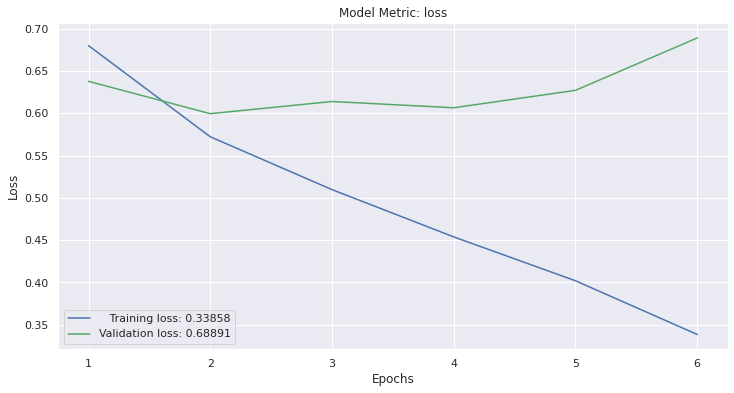

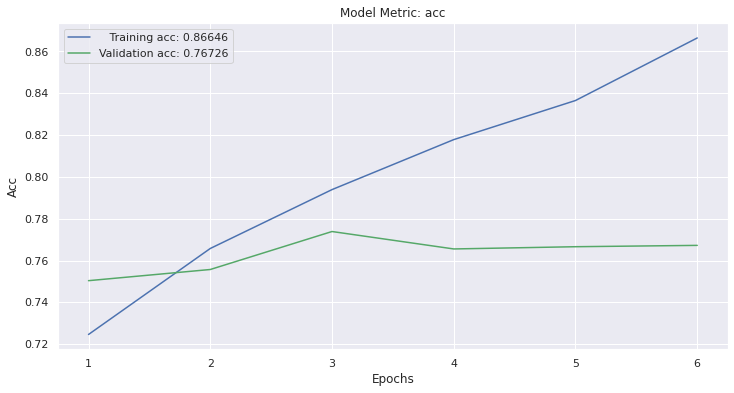

In [1564]:
import matplotlib.pyplot as plt
plot_keras_history(history2)

In [1565]:
# evaluate and store on score variable on the TEST DATASET
score = model_2.evaluate(
    data_test,    # features
    y_test_enc,              # labels
    batch_size= 32,   # batch size
    verbose=2                # the most extended verbose
)

182/182 - 8s - loss: 0.6755 - acc: 0.7670


In [1566]:
predictions = model_2.predict(data_test)

In [1567]:
y_pred = predictions.argmax(axis=1)

In [1568]:
y_test = y_test_enc.argmax(axis=1)
y_test

array([2, 2, 2, ..., 2, 0, 0])

In [1569]:
# Classification report 
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred,digits=4,labels=[0,1],target_names= ['CLAIM','EVIDENCE']))

              precision    recall  f1-score   support

       CLAIM     0.5903    0.3851    0.4661       696
    EVIDENCE     0.6667    0.5507    0.6032      1202

   micro avg     0.6427    0.4900    0.5561      1898
   macro avg     0.6285    0.4679    0.5346      1898
weighted avg     0.6387    0.4900    0.5529      1898



In [1570]:
y_enc.categories_

[array(['CLAIM', 'EVIDENCE', 'NEITHER'], dtype=object)]

In [1571]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

In [1572]:
conf_mat = confusion_matrix(y_test,
                            y_pred)

pd.DataFrame(conf_mat)

0    1     2
0  268   70   358
1   59  662   481
2  127  261  3534

In [1573]:
# How to extract weights of hidden layers with Keras API
weights = [layer.get_weights() for layer in model_2.layers]
weights

[[array([[ 0.05275026,  0.8759255 , -0.5799396 , ..., -0.14104585,
          -0.10965554, -0.2481923 ],
         [-0.21135621, -0.43935618,  0.018366  , ..., -0.28939417,
           0.29638934, -0.0244275 ],
         [ 0.04656   ,  0.21318   , -0.0074364 , ...,  0.0090611 ,
          -0.20989   ,  0.053913  ],
         ...,
         [-0.32877797,  0.7568015 , -0.42954087, ...,  0.17278506,
           0.10194901,  0.34201914],
         [-0.0885017 , -0.09336593, -0.13535121, ...,  0.41116676,
          -0.47881833,  0.16922826],
         [-0.7431085 , -0.19375199,  0.11384647, ...,  0.36198768,
          -0.27405024, -0.1831466 ]], dtype=float32)],
 [array([[ 0.10235967, -0.12020773, -0.1051188 , ...,  0.18597844,
          -0.08357748, -0.1291447 ],
         [ 0.05468216,  0.16634011,  0.00637026, ...,  0.13240567,
           0.2074822 , -0.1845842 ],
         [ 0.2019278 ,  0.13456872, -0.07895426, ..., -0.01038006,
          -0.04509534, -0.10231361],
         ...,
         [-0.11431

In [1574]:
# Creation of Graph starts here 

In [1575]:
 #pip install -U sentence-transformers

In [1576]:
# Isolation of sentences in order investigate it further 
sentences2 = data2['sentences'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'sentences': 'sentence'})

print(f'sentences dimension: {sentences2.shape}')
sentences2.tail(10)

sentences dimension: (29318, 2)


doc_id                                           sentence
29308    2685  They have played an important role in climate ...
29309    2685  Early instrumental data can also help place tw...
29310    2685  Until recently, the focus was on long, high-qu...
29311    2685  The shift in climate and climate impact resear...
29312    2685  However, information on early instrumental ser...
29313    2685  Here we attempt a worldwide compilation of met...
29314    2685  Our global inventory comprises information on ...
29315    2685  The inventory will help to prioritize data res...
29316    2685  The inventory will be maintained as a living d...
29317    2685            Additions to the inventory are welcome.

In [1577]:
# Isolation of labels in order investigate it further 
labels2 = data2['labels'].explode().reset_index().rename(
    columns={'index': 'doc_id', 'labels': 'label'})
print(f'labels dimension: {labels2.shape}')
labels2.head(10)

labels dimension: (29318, 2)


doc_id     label
0       0   NEITHER
1       0   NEITHER
2       0   NEITHER
3       0   NEITHER
4       0   NEITHER
5       0   NEITHER
6       0  EVIDENCE
7       0  EVIDENCE
8       0     CLAIM
9       1   NEITHER

In [1578]:
# Merge the 2 datasets sentences and labels  
data_exp2  = pd.concat([sentences2,labels2['label']], axis=1)
print(data_exp2.shape)
data_exp2.head(20)

(29318, 3)


doc_id                                           sentence     label
0        0  Abstract: Three Larix chinensis clusters were ...   NEITHER
1        0  The Larix chinensis all contained a lot of env...   NEITHER
2        0  Tree cycle and its response to climatic factor...   NEITHER
3        0  The results showed that the maximum sensitivit...   NEITHER
4        0  However, due to environmental factors, The inf...   NEITHER
5        0  The three tree-ring chronologies show a positi...   NEITHER
6        0  But the differences of the altitudes show that...  EVIDENCE
7        0  The results show that in the past 180 years, t...  EVIDENCE
8        0  The climatic change period Showing a decreasin...     CLAIM
9        1  This study was performed to improve our knowle...   NEITHER
10       1  We looked at the types of complications of the...   NEITHER
11       1  This was an observational study of women from ...   NEITHER
12       1  Fifty-one patients with a past history of fema...   NEITHER
13       1  We found that 77.6% of women identified as hav...   NEITHER
14       1  More than 85% of the women in our study report...  EVIDENCE
15       1  The major complications were dyspareunia, apar...  EVIDENCE
16       1  In our study group there was no difference in ...   NEITHER
17       1  Women who have had a female genital mutilation...     CLAIM
18       1  These women have significant complications rel...   NEITHER
19       1                                               LESS   NEITHER

In [1579]:
# Filter only for claims
claims2 =  pd.DataFrame(data_exp2[data_exp2['label'] == 'CLAIM'][['doc_id','sentence']])
claims2

doc_id                                           sentence
8           0  The climatic change period Showing a decreasin...
17          1  Women who have had a female genital mutilation...
29          2  Given that obtaining high resolution anatomica...
42          3  The impacts of increased ocean resolution are ...
56          4  Adding docetaxel to CF significantly improved ...
...       ...                                                ...
29277    2682  In conclusion, MBAT is associated with signifi...
29296    2683  In everyday use in LMIC, neither ‘improved’ so...
29306    2684  Denitrification represents the major pathway o...
29315    2685  The inventory will help to prioritize data res...
29316    2685  The inventory will be maintained as a living d...

[3408 rows x 2 columns]

In [1580]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

#Sentences are encoded by calling model.encode()
embeddings = model.encode(np. array(claims2.sentence))

# keep embeddings only for laims per sentece 
# creation of 2D maxtrix and find module from sklearn for similarity
# specter for graph between abstracts, then find cliques for these abstracts and the claims of them 


#Print the embeddings
for sentence, embedding in zip(claims2.sentence, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  4.80844200e-01 -3.23191397e-02  1.54640794e-01  1.11839868e-01
 -1.05953738e-02 -2.48129413e-01  2.89058208e-01 -1.84358910e-01
 -2.29636356e-01  8.74742642e-02  5.75065687e-02  4.55260903e-01
  1.69678137e-01 -1.76603824e-01  3.28278601e-01  1.89111516e-01
  3.69630516e-01  8.58104825e-02  1.21813402e-01 -5.55591643e-01
  2.63099730e-01 -1.53995520e-02 -3.35083306e-01 -1.83135718e-01
 -3.65303487e-01 -3.94829780e-01  5.86112142e-01  4.38506693e-01
  2.27602914e-01 -4.78969328e-02 -1.47221312e-01  2.51379699e-01
 -1.41605645e-01  3.34233731e-01  3.01504526e-02  1.71336174e-01
  3.83947194e-02 -5.80811687e-02 -3.72749537e-01 -6.75257221e-02
  2.55748201e-02 -6.96860254e-02  2.50320882e-01  2.82433063e-01
  6.40281960e-02  2.73954064e-01 -1.63240045e-01 -2.31723655e-02
 -1.49051279e-01  4.17800903e-01  2.15976015e-01  2.42325500e-01
 -8.49704742e-02  3.14403325e-01 -6.28764257e-02  4.05603558e-01
 -3.73071730e-01 -3.25588763e-01 -1

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  8.74593258e-02 -2.51754746e-02  2.93485254e-01 -2.60327548e-01
 -3.48834097e-01  4.50095460e-02  2.85437316e-01  2.16395527e-01
 -1.20490007e-01 -3.39066654e-01 -4.28020269e-01 -1.51343066e-02
  3.22419226e-01 -3.18268895e-01  1.01033941e-01 -1.65007696e-01
 -1.46810815e-01 -4.44149882e-01 -1.01274818e-01 -4.79457974e-01
 -4.90691274e-01  3.70791852e-02  2.22640410e-01 -1.55475020e-01
  3.16495657e-01  2.82154772e-02  3.67513120e-01  2.57398468e-02
  1.79904506e-01  4.39298451e-02  2.51498789e-01 -8.38269472e-01
  1.34038869e-02 -2.97646970e-01 -2.18723342e-01  5.18894851e-01
  1.52400911e-01  4.11342293e-01 -4.26490664e-01 -1.01472577e-02
 -3.84882092e-01 -2.30235875e-01  3.41299355e-01  2.04458058e-01
 -3.61086041e-01 -4.13618147e-01 -6.93823993e-02 -9.20802876e-02
 -1.46523014e-01  1.11469351e-01  2.92774886e-01 -7.99500495e-02
  1.18553154e-01  2.20285386e-01  7.61892647e-02  1.00788459e-01
  3.02266538e-01  5.20500183e-01  3

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  2.38704279e-01  8.08154121e-02  5.99077821e-01  1.69952158e-02
  7.90757909e-02  2.75996164e-03 -2.08539158e-01  1.21388413e-01
  3.24915290e-01 -1.85959056e-01  1.42407101e-02  2.76999086e-01
  6.82360604e-02 -2.92098284e-01  4.40854728e-02  6.22312091e-02
 -1.02621831e-01 -3.23358536e-01 -2.55195946e-01 -2.75243998e-01
  3.56221527e-01  2.45214611e-01 -3.79338698e-03 -7.70386830e-02
  1.53101847e-01  7.13120997e-02 -9.73257124e-02 -2.18691424e-01
 -3.47428769e-02  1.79970071e-01 -5.02785742e-01 -2.37225831e-01
  9.04146135e-02  4.16515619e-01  2.45869488e-01  3.19165885e-02
 -4.34357643e-01 -1.40693337e-01 -1.42672809e-03 -1.96098626e-01
  2.13686954e-02  5.83891422e-02  7.58027285e-02  1.63386643e-01
 -4.47793864e-03  1.52816042e-01 -1.88337728e-01 -8.52335524e-03
  1.45477176e-01 -3.67976911e-02  4.07915384e-01 -3.08092654e-01
 -2.78317571e-01  2.26537455e-02 -1.02159992e-01  3.60984392e-02
  1.94453999e-01  1.12612084e-01 -8

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
 -0.16447929 -0.01609013 -0.12994042  0.06112907 -0.12824126 -0.3040406
 -0.05772157  0.3241852  -0.24649681  0.28473678 -0.37712786 -0.07886766
 -0.06732719 -0.01026704 -0.1862174   0.09727555 -0.22152553 -0.0582132
 -0.0255201   0.34877774  0.38710117 -0.41576627  0.02544995  0.0960207
  0.2597283   0.20168632 -0.11227266  0.16860202 -0.03881638 -0.25698784
 -0.23579727 -0.19151928 -0.3848966  -0.09303592  0.5268282   0.02053179
 -0.01145293  0.02734788  0.02440084  0.29932     0.18593977 -0.30893028
 -0.24805441  0.11374089 -0.01690327  0.16252154 -0.20076337  0.42298225
 -0.03019636 -0.24100031  0.1231898  -0.0825742   0.31763932 -0.31730986
  0.05806841  0.1973471  -0.21744302 -0.3369832  -0.2450474  -0.4764479
  0.3284022   0.06983929  0.03785256  0.23642047  0.16181444 -0.34281915
  0.3431532   0.05260744 -0.26018566  0.00714372 -0.2527201  -0.15649997
  0.37485498  0.3633184  -0.49019873  0.48403087 -0.6035194   0.1346673
 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [1583]:
 # Check embeddings dimension
np.shape(embeddings)

(3408, 384)

In [1584]:
# Import all necessary libraries
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn import preprocessing
from statistics import *

In [1585]:
 # Compute pairwise distances 
 matrix = pairwise_distances(embeddings, Y=None, metric='euclidean')
 matrix

array([[0.       , 7.551032 , 5.941802 , ..., 6.534116 , 6.518128 ,
        6.900447 ],
       [7.551032 , 0.       , 5.7983875, ..., 7.095365 , 6.8425083,
        6.0808797],
       [5.941802 , 5.7983875, 0.       , ..., 6.2273636, 6.0402102,
        5.1495824],
       ...,
       [6.534116 , 7.095365 , 6.2273636, ..., 0.       , 6.8536906,
        6.5507374],
       [6.518128 , 6.8425083, 6.0402102, ..., 6.8536906, 0.       ,
        4.209225 ],
       [6.900447 , 6.0808797, 5.1495824, ..., 6.5507374, 4.209225 ,
        0.       ]], dtype=float32)

In [1586]:
# Convert array to matrix
matrix2 = np.asmatrix(matrix)
matrix2

matrix([[0.       , 7.551032 , 5.941802 , ..., 6.534116 , 6.518128 ,
         6.900447 ],
        [7.551032 , 0.       , 5.7983875, ..., 7.095365 , 6.8425083,
         6.0808797],
        [5.941802 , 5.7983875, 0.       , ..., 6.2273636, 6.0402102,
         5.1495824],
        ...,
        [6.534116 , 7.095365 , 6.2273636, ..., 0.       , 6.8536906,
         6.5507374],
        [6.518128 , 6.8425083, 6.0402102, ..., 6.8536906, 0.       ,
         4.209225 ],
        [6.900447 , 6.0808797, 5.1495824, ..., 6.5507374, 4.209225 ,
         0.       ]], dtype=float32)

In [1587]:
# Creation of DataFrame
claims3 = pd.DataFrame(matrix2)
claims3

0         1         2     ...      3405      3406      3407
0     0.000000  7.551032  5.941802  ...  6.534116  6.518128  6.900447
1     7.551032  0.000000  5.798388  ...  7.095365  6.842508  6.080880
2     5.941802  5.798388  0.000000  ...  6.227364  6.040210  5.149582
3     5.286337  7.032482  5.373382  ...  5.938566  5.563373  5.762733
4     7.184640  6.884488  6.030430  ...  7.112530  6.823083  6.482172
...        ...       ...       ...  ...       ...       ...       ...
3403  6.728059  6.554904  6.242542  ...  7.484945  6.056296  5.889584
3404  6.353346  6.653564  5.902724  ...  6.206340  6.115851  6.206306
3405  6.534116  7.095365  6.227364  ...  0.000000  6.853691  6.550737
3406  6.518128  6.842508  6.040210  ...  6.853691  0.000000  4.209225
3407  6.900447  6.080880  5.149582  ...  6.550737  4.209225  0.000000

[3408 rows x 3408 columns]

In [1588]:
# Rename column names according to  doc ids of the initial exploded dataframe called claims2 
claims3.columns = claims2.doc_id.tolist()
claims3

0         1         2     ...      2684      2685      2685
0     0.000000  7.551032  5.941802  ...  6.534116  6.518128  6.900447
1     7.551032  0.000000  5.798388  ...  7.095365  6.842508  6.080880
2     5.941802  5.798388  0.000000  ...  6.227364  6.040210  5.149582
3     5.286337  7.032482  5.373382  ...  5.938566  5.563373  5.762733
4     7.184640  6.884488  6.030430  ...  7.112530  6.823083  6.482172
...        ...       ...       ...  ...       ...       ...       ...
3403  6.728059  6.554904  6.242542  ...  7.484945  6.056296  5.889584
3404  6.353346  6.653564  5.902724  ...  6.206340  6.115851  6.206306
3405  6.534116  7.095365  6.227364  ...  0.000000  6.853691  6.550737
3406  6.518128  6.842508  6.040210  ...  6.853691  0.000000  4.209225
3407  6.900447  6.080880  5.149582  ...  6.550737  4.209225  0.000000

[3408 rows x 3408 columns]

In [1589]:
# Concat claims3 with claims2 dataframe, to bring  doc ids in order to  set them as index
claims3  = pd.concat([claims3,claims2.doc_id.reset_index(drop=True)],axis=1)
claims3.head(20)


0         1         2  ...      2685      2685  doc_id
0   0.000000  7.551032  5.941802  ...  6.518128  6.900447       0
1   7.551032  0.000000  5.798388  ...  6.842508  6.080880       1
2   5.941802  5.798388  0.000000  ...  6.040210  5.149582       2
3   5.286337  7.032482  5.373382  ...  5.563373  5.762733       3
4   7.184640  6.884488  6.030430  ...  6.823083  6.482172       4
5   7.733173  6.722647  5.977414  ...  6.817579  6.180123       4
6   6.518058  6.732224  5.757793  ...  6.081255  6.253046       6
7   5.951420  5.733211  5.588727  ...  6.178397  5.643347       7
8   6.115676  5.816715  5.713861  ...  6.125710  5.813623       7
9   6.182909  6.217421  5.039014  ...  6.252598  5.540178       8
10  6.492639  6.463076  5.550159  ...  6.696432  6.012076       8
11  7.161543  4.585851  5.844949  ...  7.225964  6.264452       9
12  5.544049  5.845433  5.073810  ...  6.248643  5.540336      10
13  6.221888  6.643835  6.715498  ...  6.795284  6.488324      11
14  6.601599  6.156981  5.348699  ...  6.425032  5.912977      11
15  5.746259  6.214910  4.926445  ...  5.643530  5.325253      12
16  5.775795  6.009269  4.151680  ...  5.382234  4.571190      12
17  6.974267  6.753903  5.798418  ...  7.150345  6.636859      13
18  6.028408  5.603889  5.022293  ...  5.670536  5.006551      14
19  7.271598  7.210752  6.135785  ...  6.824257  6.665677      15

[20 rows x 3409 columns]

In [1590]:
# Set doc ids as index
claims3 = claims3.set_index('doc_id')
claims3.head(20)

0         1         2     ...      2684      2685      2685
doc_id                                ...                              
0       0.000000  7.551032  5.941802  ...  6.534116  6.518128  6.900447
1       7.551032  0.000000  5.798388  ...  7.095365  6.842508  6.080880
2       5.941802  5.798388  0.000000  ...  6.227364  6.040210  5.149582
3       5.286337  7.032482  5.373382  ...  5.938566  5.563373  5.762733
4       7.184640  6.884488  6.030430  ...  7.112530  6.823083  6.482172
4       7.733173  6.722647  5.977414  ...  7.426824  6.817579  6.180123
6       6.518058  6.732224  5.757793  ...  6.484271  6.081255  6.253046
7       5.951420  5.733211  5.588727  ...  6.820744  6.178397  5.643347
7       6.115676  5.816715  5.713861  ...  6.626950  6.125710  5.813623
8       6.182909  6.217421  5.039014  ...  6.543292  6.252598  5.540178
8       6.492639  6.463076  5.550159  ...  6.886521  6.696432  6.012076
9       7.161543  4.585851  5.844949  ...  7.127937  7.225964  6.264452
10      5.544049  5.845433  5.073810  ...  6.102679  6.248643  5.540336
11      6.221888  6.643835  6.715498  ...  7.560764  6.795284  6.488324
11      6.601599  6.156981  5.348699  ...  6.259585  6.425032  5.912977
12      5.746259  6.214910  4.926445  ...  6.335293  5.643530  5.325253
12      5.775795  6.009269  4.151680  ...  6.319832  5.382234  4.571190
13      6.974267  6.753903  5.798418  ...  7.105244  7.150345  6.636859
14      6.028408  5.603889  5.022293  ...  6.369601  5.670536  5.006551
15      7.271598  7.210752  6.135785  ...  7.133079  6.824257  6.665677

[20 rows x 3408 columns]

In [1591]:
# Summarize indexes with mean agg function
claims4 = claims3.groupby(claims3.index).mean()
# Transpose to summarize and the respective columns
claims4  = claims4.transpose()
claims4.head(20)

doc_id      0         1         2     ...      2683      2684      2685
0       0.000000  7.551032  5.941802  ...  6.353346  6.534116  6.709288
1       7.551032  0.000000  5.798388  ...  6.653564  7.095365  6.461694
2       5.941802  5.798388  0.000000  ...  5.902724  6.227364  5.594896
3       5.286337  7.032482  5.373382  ...  6.315525  5.938566  5.663053
4       7.184640  6.884488  6.030430  ...  6.284017  7.112530  6.652627
4       7.733173  6.722647  5.977414  ...  6.727978  7.426824  6.498851
6       6.518058  6.732224  5.757793  ...  5.952434  6.484271  6.167150
7       5.951420  5.733211  5.588727  ...  5.788768  6.820744  5.910872
7       6.115676  5.816715  5.713861  ...  6.038579  6.626950  5.969666
8       6.182909  6.217421  5.039014  ...  5.509237  6.543292  5.896388
8       6.492639  6.463076  5.550159  ...  5.644913  6.886521  6.354254
9       7.161543  4.585851  5.844949  ...  7.304430  7.127937  6.745208
10      5.544049  5.845433  5.073810  ...  6.099864  6.102679  5.894490
11      6.221888  6.643835  6.715498  ...  6.654112  7.560764  6.641804
11      6.601599  6.156981  5.348699  ...  5.915088  6.259585  6.169004
12      5.746259  6.214910  4.926445  ...  5.691962  6.335293  5.484391
12      5.775795  6.009269  4.151680  ...  5.423389  6.319832  4.976712
13      6.974267  6.753903  5.798418  ...  7.002117  7.105244  6.893602
14      6.028408  5.603889  5.022293  ...  5.593954  6.369601  5.338543
15      7.271598  7.210752  6.135785  ...  7.115217  7.133079  6.744967

[20 rows x 2413 columns]

In [1592]:
claims5 = claims4.groupby(claims4.index).mean()
claims5.head(20)

doc_id      0         1         2     ...      2683      2684      2685
0       0.000000  7.551032  5.941802  ...  6.353346  6.534116  6.709288
1       7.551032  0.000000  5.798388  ...  6.653564  7.095365  6.461694
2       5.941802  5.798388  0.000000  ...  5.902724  6.227364  5.594896
3       5.286337  7.032482  5.373382  ...  6.315525  5.938566  5.663053
4       7.458907  6.803567  6.003922  ...  6.505998  7.269677  6.575739
6       6.518058  6.732224  5.757793  ...  5.952434  6.484271  6.167150
7       6.033548  5.774963  5.651294  ...  5.913674  6.723847  5.940269
8       6.337774  6.340248  5.294587  ...  5.577075  6.714906  6.125321
9       7.161543  4.585851  5.844949  ...  7.304430  7.127937  6.745208
10      5.544049  5.845433  5.073810  ...  6.099864  6.102679  5.894490
11      6.411743  6.400408  6.032099  ...  6.284600  6.910174  6.405404
12      5.761027  6.112089  4.539062  ...  5.557675  6.327562  5.230552
13      6.974267  6.753903  5.798418  ...  7.002117  7.105244  6.893602
14      6.028408  5.603889  5.022293  ...  5.593954  6.369601  5.338543
15      7.271598  7.210752  6.135785  ...  7.115217  7.133079  6.744967
16      7.930057  6.867921  6.598032  ...  7.204702  7.672042  6.983509
17      6.435122  6.120840  5.330203  ...  6.332629  6.607926  6.094297
18      7.171230  6.338445  6.006311  ...  6.061400  6.752635  6.150765
19      7.603364  7.386309  7.043324  ...  6.596568  7.809735  7.371226
20      6.374372  6.212517  5.324735  ...  5.813441  6.634398  6.040611

[20 rows x 2413 columns]

In [1593]:
# Find the maximum element of the matrix
round(claims5.max().max(),2)

9.95

In [1594]:
# Calculate the average value of the matrix 
round(claims5.mean().mean(),2)

6.42

In [1595]:
# Verify the above calculation
round(claims5.sum().sum()/(claims5.shape[0]*claims5.shape[1]),2)

6.42

In [1596]:
# Set threshold, according to above statistic metrics
claims5 = claims5 <= 4
claims5

doc_id   0      1      2      3      4     ...   2681   2682   2683   2684   2685
0        True  False  False  False  False  ...  False  False  False  False  False
1       False   True  False  False  False  ...  False  False  False  False  False
2       False  False   True  False  False  ...  False  False  False  False  False
3       False  False  False   True  False  ...  False  False  False  False  False
4       False  False  False  False   True  ...  False  False  False  False  False
...       ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
2681    False  False  False  False  False  ...   True  False  False  False  False
2682    False  False  False  False  False  ...  False   True  False  False  False
2683    False  False  False  False  False  ...  False  False   True  False  False
2684    False  False  False  False  False  ...  False  False  False   True  False
2685    False  False  False  False  False  ...  False  False  False  False   True

[2413 rows x 2413 columns]

In [1597]:
# Convert False/True to 0/1
claims5 = claims5.astype(int)
claims5.head(10)


doc_id  0     1     2     3     4     6     ...  2680  2681  2682  2683  2684  2685
0          1     0     0     0     0     0  ...     0     0     0     0     0     0
1          0     1     0     0     0     0  ...     0     0     0     0     0     0
2          0     0     1     0     0     0  ...     0     0     0     0     0     0
3          0     0     0     1     0     0  ...     0     0     0     0     0     0
4          0     0     0     0     1     0  ...     0     0     0     0     0     0
6          0     0     0     0     0     1  ...     0     0     0     0     0     0
7          0     0     0     0     0     0  ...     0     0     0     0     0     0
8          0     0     0     0     0     0  ...     0     0     0     0     0     0
9          0     0     0     0     0     0  ...     0     0     0     0     0     0
10         0     0     0     0     0     0  ...     0     0     0     0     0     0

[10 rows x 2413 columns]

In [1598]:
# Creation of a  subset of the original dataframe to visualize a more aisthetic graph
claims6 = claims5.iloc[0:300, 0:300]

In [1599]:
# Initialization of graphs
import networkx as nx
G = nx.Graph()
G_sub = nx.Graph()

In [1600]:
# Creation of adjacency matrix
G = nx.from_pandas_adjacency(claims5)
G_sub = nx.from_pandas_adjacency(claims6)

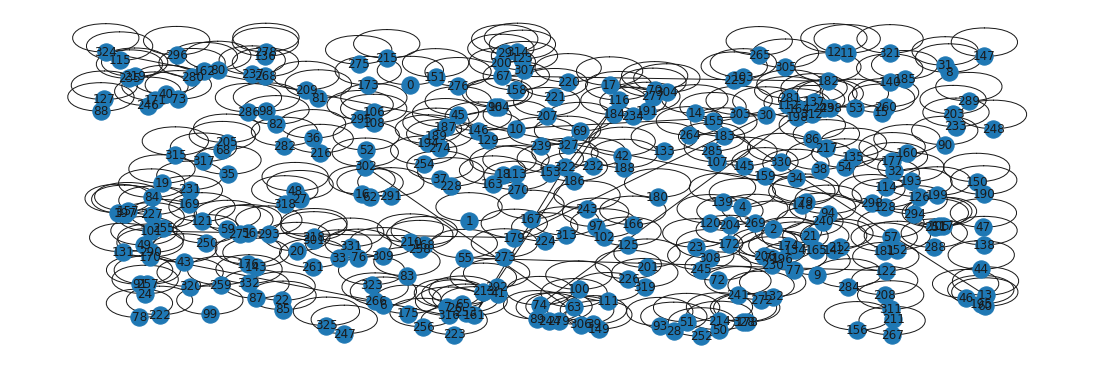

In [1601]:
# Visualize graph with subset dataframe, with self loops
from numbers import Number
import networkx as nx
from matplotlib.pyplot import figure
figure(figsize=(15, 5))
nx.draw_random(G_sub,with_labels=True)

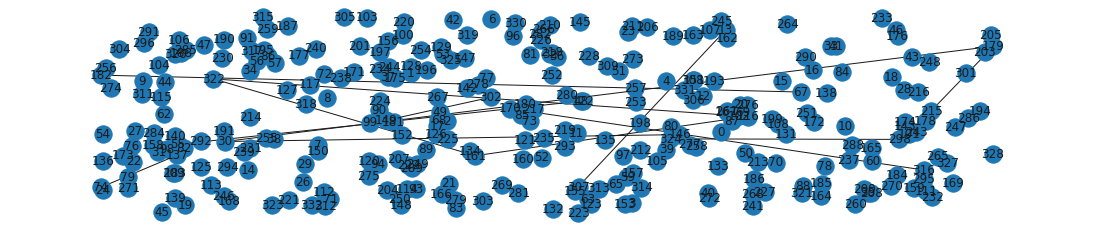

In [1602]:
# Visualize graph with subset dataframe, removing self loops
G_sub.remove_edges_from(nx.selfloop_edges(G_sub))
nx.draw_random(G_sub,with_labels=True)

In [1603]:
# Find all the cliques, containing in the graph G
from networkx.algorithms.approximation import clique
cliques_list = list(nx.enumerate_all_cliques(G))
cliques_list 

[[0],
 [1],
 [2],
 [3],
 [4],
 [2568],
 [2302],
 [2067],
 [1852],
 [1658],
 [1482],
 [1320],
 [1180],
 [1055],
 [938],
 [840],
 [753],
 [677],
 [611],
 [551],
 [499],
 [455],
 [414],
 [376],
 [341],
 [2442],
 [308],
 [2192],
 [278],
 [1969],
 [253],
 [1762],
 [230],
 [1575],
 [209],
 [1405],
 [189],
 [1255],
 [171],
 [1121],
 [153],
 [1001],
 [136],
 [891],
 [121],
 [798],
 [108],
 [714],
 [99],
 [642],
 [90],
 [580],
 [83],
 [525],
 [76],
 [477],
 [69],
 [2535],
 [433],
 [63],
 [2669],
 [2525],
 [2270],
 [394],
 [59],
 [2484],
 [2397],
 [2261],
 [2041],
 [358],
 [56],
 [2561],
 [2228],
 [2151],
 [2033],
 [1830],
 [323],
 [54],
 [2295],
 [2001],
 [1931],
 [1823],
 [1638],
 [292],
 [52],
 [2061],
 [1792],
 [1730],
 [1632],
 [1465],
 [265],
 [50],
 [2488],
 [2435],
 [1846],
 [1604],
 [1546],
 [1460],
 [1306],
 [240],
 [48],
 [2612],
 [2605],
 [2232],
 [2185],
 [1652],
 [1433],
 [1377],
 [1302],
 [1168],
 [218],
 [46],
 [2634],
 [2550],
 [2536],
 [2342],
 [2336],
 [2005],
 [1962],
 [1478]

In [1604]:
# Choose a random clique
from networkx.algorithms.approximation import clique
list(nx.enumerate_all_cliques(G))[4000]

[823, 1270, 1663]

In [1605]:
# Mapping the sentences with the inital dataframe
claims2[claims2['doc_id']== 372 ].sentence.tolist()

['In patients with advanced NSCLC, GCa chemotherapy was shown to be a better-tolerated treatment that conferred a survival advantage over MIC.']

In [1606]:
# Mapping the sentences with the inital dataframe
claims2[claims2['doc_id']== 2422 ].sentence.tolist()

['This novel approach shows that vigorous physical activity is strongest related to metabolic health.']

In [1607]:
# Mapping the sentences with the inital dataframe
claims2[claims2['doc_id']== 2681 ].sentence.tolist()

['Due to this lack of distortions, probe diffusion strongly enhances the SOFI imaging by avoiding spatial undersampling caused by the limited labeling density. ispartof: Scientific Reports vol:7 pages:44665- ispartof: location:England status: published']

In [1608]:
# End of Code